# Mock Observations with MUSTANG-2

In [2]:
from plotting_scripts import * 

In [3]:
from maria import Simulation
from maria.map.mappers import BinMapper
from maria import TOD
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 


# Load in real TOD

In [4]:
# from maria.utils.io import fetch_cache

# TEST_MAP_URL = (
#     "https://github.com/thomaswmorris/maria-data/raw/master/maps/cluster.fits"
# )

# fetch_cache(TEST_MAP_URL, "/tmp/cluster.fits", refresh=True)

In [5]:
months = np.array(['JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC'])

def time_converter(time):
    month  = np.where(months == time.split('-')[1])[0]+1
    year  = (time.split('-')[2])[:4]
    day   = time.split('-')[0]
    time  = time.split('.')[0][-8:]
    return "{}-{:02d}-{:02d}T{}".format(year,int(month),int(day),time)

In [6]:
def circle_mask(im, xc, yc, rcirc):
        ny, nx = im.shape
        y,x = np.mgrid[0:nx,0:ny]
        r = np.sqrt((x-xc)*(x-xc) + (y-yc)*(y-yc))
        return ( (r < rcirc))

def r_theta(im, xc, yc):
    # returns the radius rr and the angle phi for point (xc,yc)
    ny, nx = im.shape
    yp, xp = np.mgrid[0:ny,0:nx]
    yp = yp - yc
    xp = xp - xc
    rr = np.sqrt(np.power(yp,2.) + np.power(xp,2.))
    phi = np.arctan2(yp, xp)
    return(rr, phi)    

def binit(a, size):
    return np.mean(a.reshape(len(a) // size, size), axis=1)

# Set up Sim

In [9]:
pixel_size = 8.71452898559111e-05
# sample_rate = 100
sample_rate = 50
scan_velocity = 53/3600

inputfile = "/tmp/cluster.fits"
outfile_map = "/tmp/empty.fits"

atm_model = "2d"

### Initialize
First we need to initialize the telescope and weather conditions

In [10]:
import os
def get_signal_files(directory_path):
    # Get the list of files in the directory
    file_list = os.listdir(directory_path)

    # Filter files that start with "Signal"
    signal_files = [filename for filename in file_list if filename.startswith('Signal')]

    return signal_files


In [12]:
dir = "/Users/jvanmarr/Documents/Papers/maria/sims/data/M2-data/New/TS_EaCMS0f0_51_19_Dec_2023/"
fls = get_signal_files(dir)

# The normal one

In [9]:
i_file = 3
filename = fls[i_file]

mustang2_tod_file = dir + filename
tod_real = TOD.from_fits(fname=mustang2_tod_file, format='mustang-2')
hdu_table = fits.open(mustang2_tod_file)

pointing_center = (np.degrees(hdu_table[1].data['DX'].mean()), np.degrees(hdu_table[1].data['DY'].mean()))
obs_time = time_converter(hdu_table[1].header['OBSSTART'])
integration_time = ((hdu_table[1].data['TIME'][-1]).astype(int)).astype(float)

# - Input figure
hdu = fits.open(inputfile)
hdu[0].data = hdu[0].data
header = hdu[0].header

header["CDELT1"] = pixel_size  # degree
header["CDELT2"] = pixel_size  # degree
header["CTYPE1"] = "RA---SIN"
header["CUNIT1"] = "deg     "
header["CTYPE2"] = "DEC--SIN"
header["CUNIT2"] = "deg     "
header["CRVAL1"] = pointing_center[0]
header["CRVAL2"] = pointing_center[1]

wcs_input = WCS(header, naxis=2)

sim = Simulation(
    # Mandatory minimal weither settings
    # ---------------------
    instrument="MUSTANG-2",  # Array type
    pointing="daisy",  # Scanning strategy
    site="green_bank",  # Site    
    atmosphere_model=atm_model, #atmospheric model
    
    # True sky input
    # ---------------------
    # map_file=inputfile,          # Input files must be a fits file.
    # map_units="Jy/pixel",        # Units of the input map in Kelvin Rayleigh Jeans (K, defeault) or Jy/pixel
    
    map_res=pixel_size,          # resolution of the map
    map_center=pointing_center,  # RA & Dec in degree
    map_freqs = [93],

    # MUSTANG-2 Observational setup
    # ----------------------------s
    scan_options = {
        "radius":  4.0 / 60.0,  # The radius of the Daisy scan in degrees
        "speed":  scan_velocity # scan velocity in when the scan goes through the center deg/s
    },

    bands = {
    'f093':{
      'n_dets': 217,
      'band_center': 92,
      'band_width': 30,
      'efficiency': 0.5,
      'white_noise': 1.7e-3 * 0.3 / 1.25, # in K_RJ s^-1/2
      'pink_noise': 1.8     * 0.3 / 1.25   # in K_RJ s^-1/2}
        }
    },
    
    integration_time=integration_time,  # Seconds
    sample_rate=sample_rate,  # Hz
    scan_center=pointing_center,  # Degrees
    pointing_frame="ra_dec",  # Frame
    start_time = obs_time,
    
    pwv_rms_frac=0.005, #level of atmospheric fluctuations
    verbose=False
)

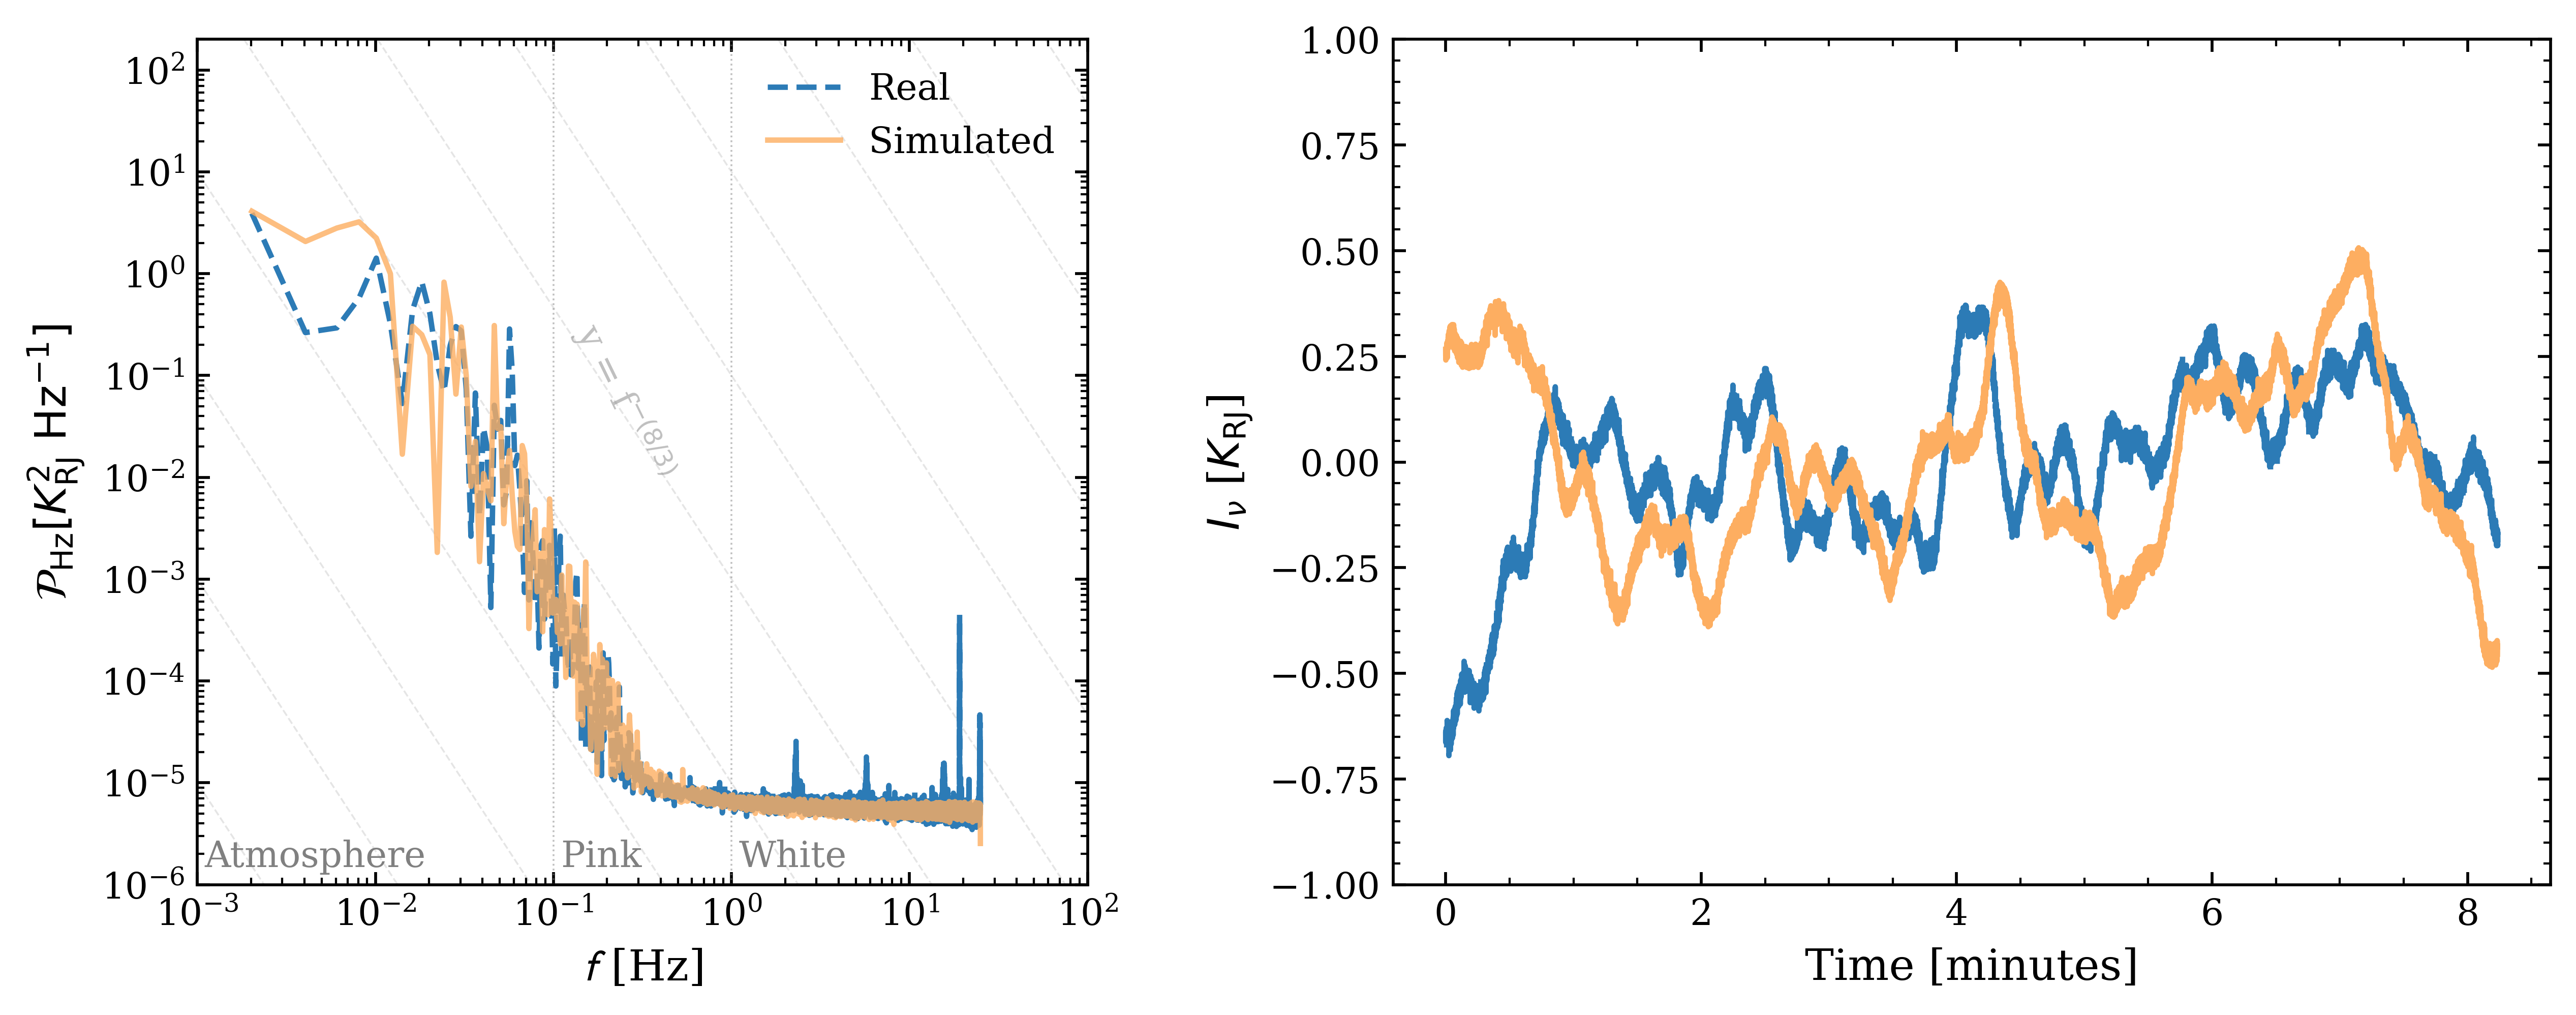

In [11]:
tod = sim.run()

time_raw_maria = binit(tod.time, 2)
tod_raw_maria_cal = np.empty((len(tod.data), tod.data.shape[1] // 2))
for i in range(len(tod.data)):
    # tod_raw_maria_cal[i] = binit(tod.data[i], 2)
    tod_raw_maria_cal[i] = binit(tod.data_calibrated[i], 2)
    
f_raw_maria_cal, ps_raw_maria_cal = sp.signal.periodogram(tod_raw_maria_cal, fs=1 / (time_raw_maria[1] - time_raw_maria[0]), window="tukey")

time_raw = tod_real.time - tod_real.time[0]
tod_raw  = tod_real.data.copy()
f_raw, ps_raw = sp.signal.periodogram(tod_real.data, fs=1/(tod_real.time[1] - tod_real.time[0]), window="tukey")

# plot_timestreams(time_raw_maria, tod_raw_maria_cal, f_raw_maria_cal, ps_raw_maria_cal, time_raw, tod_raw, f_raw, ps_raw, i_file, real= False)
plot_timestreams(time_raw_maria, tod_raw_maria_cal, f_raw_maria_cal, ps_raw_maria_cal, time_raw, tod_raw, f_raw, ps_raw, i_file, real=True)

In [12]:
mapper = BinMapper(
    center=(tod.coords.center_ra, tod.coords.center_dec),
    frame="ra_dec",
    width=np.radians(15.0 / 60.0),
    height=np.radians(15.0 / 60.0),
    res=np.radians(2.0 / 3600.0),
    degrees=False,
    calibrate = True,
    tod_postprocessing={"remove_modes": {"n": 1}, "highpass": {"f": 0.08}, "despline":{}},
    map_postprocessing={"gaussian_filter": {"sigma": 2}},
    tods=tod,
)

mapper.add_tods(tod)
mapper.run()
mapper.save_maps(outfile_map.replace('.fits', f'_maria_{i_file}.fits'))

mapper_real = BinMapper(
    center=(tod.coords.center_ra, tod.coords.center_dec),
    frame="ra_dec",
    width=np.radians(15.0 / 60.0),
    height=np.radians(15.0 / 60.0),
    res=np.radians(2.0 / 3600.0),
    degrees=False,
    calibrate = False,
    tod_postprocessing={"remove_modes": {"n": 1}, "highpass": {"f": 0.08}, "despline":{}},
    map_postprocessing={"gaussian_filter": {"sigma": 2}},
    tods=tod,
)

mapper_real.add_tods(tod_real)
mapper_real.run()
mapper_real.save_maps(outfile_map.replace('.fits', f'_real_{i_file}.fits'))

In [14]:
np.std(mapper.DATA[0])/np.std(mapper_real.DATA[0])

1.2903923993069153

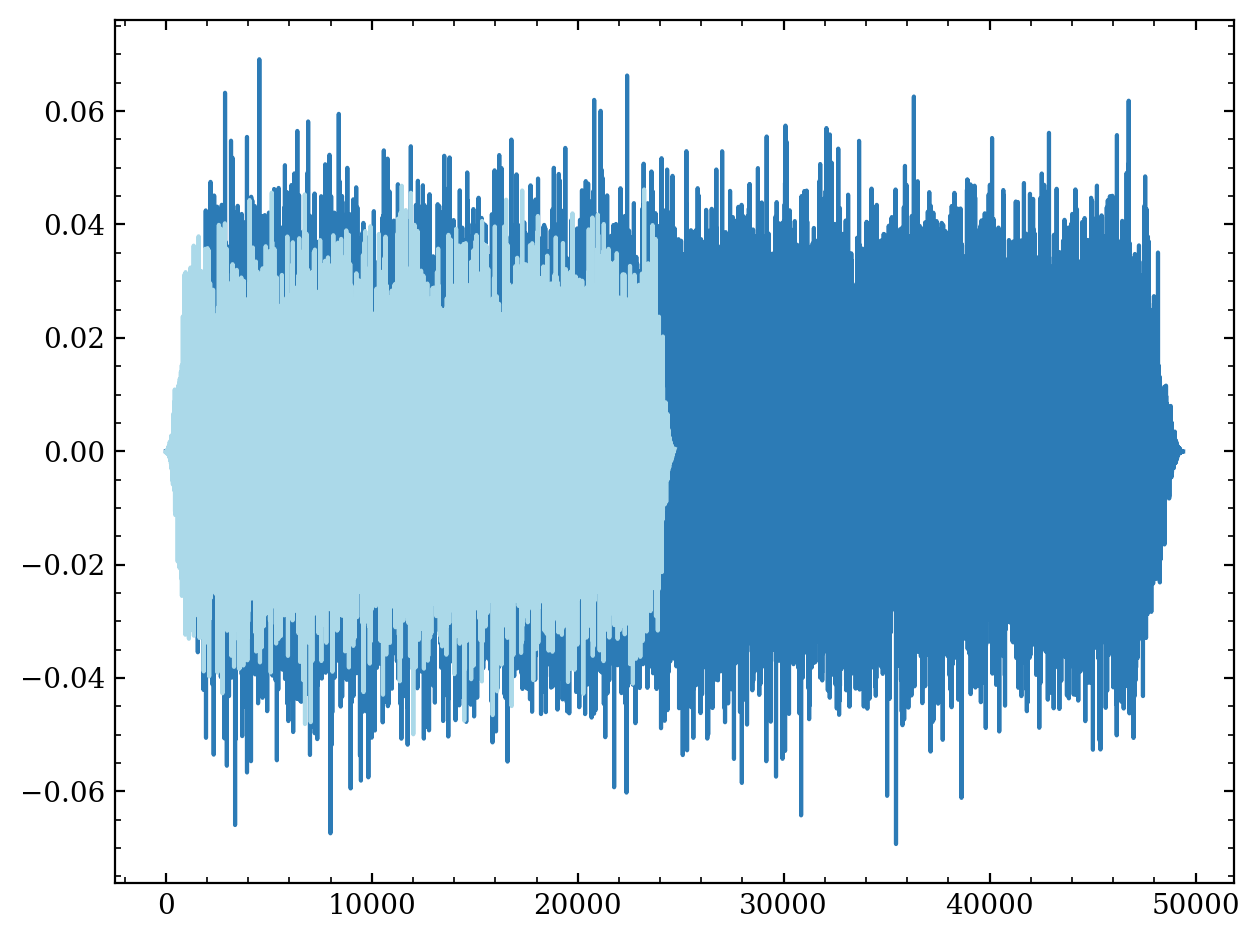

In [15]:
plt.plot(mapper.DATA[0])
plt.plot(mapper_real.DATA[0])

In [16]:
time_raw_maria = binit(tod.time, 2)
tod_raw_maria_cal = np.empty((len(mapper.DATA), mapper.DATA.shape[1] // 2))
for i in range(len(mapper.DATA)):
    tod_raw_maria_cal[i] = binit(mapper.DATA[i], 2)
    
f_raw_maria_cal, ps_raw_maria_cal = sp.signal.periodogram(tod_raw_maria_cal, fs=1 / (time_raw_maria[1] - time_raw_maria[0]), window="tukey")

time_raw = tod_real.time - tod_real.time[0]
tod_raw  = mapper_real.DATA.copy()
f_raw, ps_raw = sp.signal.periodogram(mapper_real.DATA, fs=1/(tod_real.time[1] - tod_real.time[0]), window="tukey")

In [ ]:
def plot_timestreams(time_maria, tod_maria, f_maria, ps_maria, time_real, tod_real, f_real, ps_real, i_file, real =True):

    # visualize raw spectrum
    # -----------------------

    fig, axes = plt.subplots(1, 2, figsize=(10, 4), dpi=512, tight_layout=True, gridspec_kw={'width_ratios': [1, 1.3]})
    
    for i in range(-20,20,2): axes[0].plot(np.logspace(-7, 3,100), np.logspace(-7, 3,100) ** (-8 / 3)/1e11/(10**i), c = 'gray', alpha = 0.2, ls = '--', lw = 0.5)
    axes[0].text(1.2e-1,1e-2, r"y = f$^{-(8/3)}$", c = 'gray', alpha = 0.5, rotation = -64)
    axes[0].axvline(1e-1, c = 'gray', lw = 0.5, alpha = 0.5, ls = ':')
    axes[0].axvline(1e+0, c = 'gray', lw = 0.5, alpha = 0.5, ls = ':')
    
    # axes[0].text(1.1e-3, 1.5e-6, 'Atmosphere', color = 'gray', fontsize = 10)
    # axes[0].text(1.1e-1, 1.5e-6, 'Pink', color = 'gray', fontsize = 10)
    # axes[0].text(1.1e+0, 1.5e-6, 'White', color = 'gray', fontsize = 10)

    axes[0].plot(f_real[1:], ps_real.mean(axis=0)[1:], label="Real", alpha = 1., c = 'C0', lw = 1.5, ls = '--', rasterized=True)
    axes[0].plot(f_maria[1:], ps_maria.mean(axis=0)[1:], label="Simulated", alpha = 0.8, c = 'C2', lw = 1.5, rasterized=True)

    # axes[0].plot(f_real[1:], ps_real[0][1:], label="Real", alpha = 1., c = 'C0', lw = 1.5, ls = '--', rasterized=True)
    # axes[0].plot(f_maria[1:], ps_maria[0][1:], label="Simulated", alpha = 0.8, c = 'C2', lw = 1.5, rasterized=True)

    
    axes[0].set_xlabel(r"$\mathcal{f}$ [Hz]", fontsize = 12), 
    axes[0].set_ylabel(r"$\mathcal{P}_{\rm Hz}[K_{\rm RJ}^2~{\rm Hz}^{-1}]$", fontsize = 12)
    axes[0].loglog()
    axes[0].legend(loc = 1, frameon=False)
    
    axes[0].axis(xmin=1e-3, xmax = 1e2, ymin = 1e-10, ymax = 1e-2)
    axes[1].set_xlabel('Time [minutes]', fontsize = 12), axes[1].set_ylabel("\n"+r'$I_\nu$ [$K_{\rm RJ}$]', fontsize = 12)

    # ln1 = axes[1].plot(time_real/60, (tod_real.mean(axis=0)), label = 'Real', alpha = 1., c = 'C0', lw = 1.5, ls = '--', rasterized=True)
    # ln2 = axes[1].plot((time_maria-time_maria[0])/60, (tod_maria.mean(axis=0)), label = 'Simulated', alpha = 1., c = 'C2', lw = 1.5, rasterized=True)

    ln1 = axes[1].plot(time_real/60, (tod_real[0]), label = 'Real', alpha = 1., c = 'C0', lw = 1.5, ls = '--', rasterized=True)
    ln2 = axes[1].plot((time_maria-time_maria[0])/60, (tod_maria[0]), label = 'Simulated', alpha = 1., c = 'C2', lw = 1.5, rasterized=True)

    
    # axes[1].axis(ymin = -0.001, ymax = 0.001)
    plt.show()

In [ ]:
plot_timestreams(time_raw_maria, tod_raw_maria_cal, f_raw_maria_cal, ps_raw_maria_cal, time_raw, tod_raw, f_raw, ps_raw, i_file, real=True)

In [ ]:
# plt.plot(mapper.DATA[0], label = 'fake unbinned')
plt.plot(mapper_real.DATA[0], label = 'real')
plt.plot(tod_raw_maria_cal[0], label = 'fake binned')
plt.legend()

In [ ]:
lower = SkyCoord(ra = (pointing_center[0]-7.5/60)*u.deg, dec=(pointing_center[1]-7.5/60.0)*u.deg)
upper = SkyCoord(ra = (pointing_center[0]+7.5/60)*u.deg, dec=(pointing_center[1]+7.5/60.0)*u.deg)

In [ ]:
# - Plot Mock observation
outputfile = outfile_map.replace('.fits', f'_maria_{i_file}.fits')

hdu_out = fits.open(outputfile)
wcs_output = WCS(hdu_out[0].header, naxis=2)

ims      = hdu_out[0].data[0] * 1e3
mask    = circle_mask(ims, len(ims)//2, len(ims)//2, 60)
std     = np.std(ims[mask])
beam_area = np.pi * 4**2

# - Plot
fig = plt.figure(dpi=256, tight_layout=False)
fig.set_size_inches(6, 4, forward=True)

ax = plt.subplot(1, 1, 1, projection=wcs_output)
ax.set_title("Synthetic Observation")

im = ax.imshow(hdu_out[0].data[0]*1e3, cmap=cmap, vmin=-.4, vmax=.4, rasterized = True)

cbar = plt.colorbar(im, ax=ax, shrink=1.0)
cbar.set_label(r"I$_{\nu}$ [mK$_{\rm RJ}$]")
ax.set_aspect(1)
ra, dec = ax.coords
ra.set_major_formatter("hh:mm:ss")
dec.set_major_formatter("dd:mm:ss")
ra.set_axislabel(r"RA [J2000]", size=11)
dec.set_axislabel(r"Dec [J2000]", size=11)
ra.set_separator(("h", "m"))

pixel_lower = wcs_output.world_to_pixel(lower)
pixel_upper = wcs_output.world_to_pixel(upper)

ax.axis(xmax=pixel_lower[0], xmin =pixel_upper[0], ymin=pixel_lower[1], ymax=pixel_upper[1])
plt.tight_layout()
plt.savefig(f'/Users/jvanmarr/Documents/Papers/mock_obs/paper_plots/fake_empty_map.pdf', dpi = fig.dpi)
plt.show()

print(std, std/(np.sum(mask/beam_area))**0.5)

# - Plot Mock observation
outputfile = outfile_map.replace('.fits', f'_real_{i_file}.fits')

hdu_out = fits.open(outputfile)
wcs_output = WCS(hdu_out[0].header, naxis=2)

ims     = hdu_out[0].data[0] * 1e3
mask    = circle_mask(ims, len(ims)//2, len(ims)//2, 60)
std     = np.std(ims[mask])

print(std,std/(np.sum(mask/beam_area))**0.5)

# - Plot
fig = plt.figure(dpi=256, tight_layout=False)
fig.set_size_inches(6, 4, forward=True)

ax = plt.subplot(1, 1, 1, projection=wcs_output)
ax.set_title("Real Observation")

im = ax.imshow(hdu_out[0].data[0]*1e3, cmap=cmap, vmin=-.4, vmax=.4, rasterized = True)
ax.set_aspect(1)

cbar = plt.colorbar(im, ax=ax, shrink=1.0)
cbar.set_label(r"I$_{\nu}$ [mK$_{\rm RJ}$]")

ra, dec = ax.coords
ra.set_major_formatter("hh:mm:ss")
dec.set_major_formatter("dd:mm:ss")
ra.set_axislabel(r"RA [J2000]", size=11)
dec.set_axislabel(r"Dec [J2000]", size=11)
ra.set_separator(("h", "m"))

pixel_lower = wcs_output.world_to_pixel(lower)
pixel_upper = wcs_output.world_to_pixel(upper)

ax.axis(xmax=pixel_lower[0], xmin =pixel_upper[0], ymin=pixel_lower[1], ymax=pixel_upper[1])
plt.tight_layout()
plt.savefig(f'/Users/jvanmarr/Documents/Papers/mock_obs/paper_plots/real_empty_map.pdf', dpi = fig.dpi)
plt.show()

# The intense one

In [ ]:
# i_file=8
# filename=fls[i_file]

# mustang2_tod_file = dir + filename
# tod_real = TOD.from_fits(fname=mustang2_tod_file, format='mustang-2')
# hdu_table = fits.open(mustang2_tod_file)

# pointing_center = (np.degrees(hdu_table[1].data['DX'].mean()), np.degrees(hdu_table[1].data['DY'].mean()))
# obs_time = time_converter(hdu_table[1].header['OBSSTART'])
# integration_time = ((hdu_table[1].data['TIME'][-1]).astype(int)).astype(float)

# # - Input figure
# hdu = fits.open(inputfile)
# hdu[0].data = hdu[0].data
# header = hdu[0].header

# header["CDELT1"] = pixel_size  # degree
# header["CDELT2"] = pixel_size  # degree
# header["CTYPE1"] = "RA---SIN"
# header["CUNIT1"] = "deg     "
# header["CTYPE2"] = "DEC--SIN"
# header["CUNIT2"] = "deg     "
# header["CRVAL1"] = pointing_center[0]
# header["CRVAL2"] = pointing_center[1]

# wcs_input = WCS(header, naxis=2)
# time_raw = tod_real.time - tod_real.time[0]
# tod_raw  = tod_real.data.copy()
# f_raw, ps_raw = sp.signal.periodogram(tod_real.data, fs=1/(tod_real.time[1] - tod_real.time[0]), window="tukey")


# for pwv_rmss in np.arange(0.005, 0.055, 0.005):

#     sim = Simulation(
#         # Mandatory minimal weither settings
#         # ---------------------
#         instrument="MUSTANG-2",  # Array type
#         pointing="daisy",  # Scanning strategy
#         site="green_bank",  # Site    
#         atmosphere_model=atm_model, #atmospheric model
        
#         # True sky input
#         # ---------------------
#         # map_file=inputfile,          # Input files must be a fits file.
#         # map_units="Jy/pixel",        # Units of the input map in Kelvin Rayleigh Jeans (K, defeault) or Jy/pixel
        
#         map_res=pixel_size,          # resolution of the map
#         map_center=pointing_center,  # RA & Dec in degree
#         map_freqs = [93],
    
#         # MUSTANG-2 Observational setup
#         # ----------------------------s
#         scan_options = {
#             "radius":  4.0 / 60.0,  # The radius of the Daisy scan in degrees
#             "speed":  scan_velocity # scan velocity in when the scan goes through the center deg/s
#         },
    
#         bands = {
#         'f093':{
#           'n_dets': 217,
#           'band_center': 92,
#           'band_width': 30,
#           'efficiency': 0.5,
#           'white_noise': 1.7e-3 * 0.3 / 1.25, # in K_RJ s^-1/2
#           'pink_noise': 1.2     * 0.3 / 1.25   # in K_RJ s^-1/2}
#             }
#         },
    
        
#         integration_time=integration_time,  # Seconds
#         sample_rate=sample_rate,  # Hz
#         scan_center=pointing_center,  # Degrees
#         pointing_frame="ra_dec",  # Frame
#         start_time = obs_time,
        
#         pwv_rms_frac=pwv_rmss, #level of atmospheric fluctuations
#         verbose=False
#     )
    
#     tod = sim.run()

#     time_raw_maria = binit(tod.time, 2)
#     tod_raw_maria_cal = np.empty((len(tod.data), tod.data.shape[1] // 2))
#     for i in range(len(tod.data)):
#         tod_raw_maria_cal[i] = binit(tod.data_calibrated[i], 2)
        
#     f_raw_maria_cal, ps_raw_maria_cal = sp.signal.periodogram(tod_raw_maria_cal, fs=1 / (time_raw_maria[1] - time_raw_maria[0]), window="tukey")
    
#     plot_timestreams(time_raw_maria, tod_raw_maria_cal, f_raw_maria_cal, ps_raw_maria_cal, time_raw, tod_raw, f_raw, ps_raw, i_file)

#     np.save(
#         "/Users/jvanmarr/Documents/Papers/mock_obs/output/9min_change_pwvrms_{}rms.npy".format(
#            str(pwv_rmss).split(".")[-1]
#         ),
#         np.array([f_raw_maria_cal, ps_raw_maria_cal.mean(axis=0)]),
#         allow_pickle=True,
#     )

In [ ]:
# i_file=8
# filename=fls[i_file]

# mustang2_tod_file = dir + filename
# tod_real = TOD.from_fits(fname=mustang2_tod_file, format='mustang-2')
# hdu_table = fits.open(mustang2_tod_file)

# pointing_center = (np.degrees(hdu_table[1].data['DX'].mean()), np.degrees(hdu_table[1].data['DY'].mean()))
# obs_time = time_converter(hdu_table[1].header['OBSSTART'])
# integration_time = ((hdu_table[1].data['TIME'][-1]).astype(int)).astype(float)

# # - Input figure
# hdu = fits.open(inputfile)
# hdu[0].data = hdu[0].data
# header = hdu[0].header

# header["CDELT1"] = pixel_size  # degree
# header["CDELT2"] = pixel_size  # degree
# header["CTYPE1"] = "RA---SIN"
# header["CUNIT1"] = "deg     "
# header["CTYPE2"] = "DEC--SIN"
# header["CUNIT2"] = "deg     "
# header["CRVAL1"] = pointing_center[0]
# header["CRVAL2"] = pointing_center[1]

# wcs_input = WCS(header, naxis=2)
# time_raw = tod_real.time - tod_real.time[0]
# tod_raw  = tod_real.data.copy()
# f_raw, ps_raw = sp.signal.periodogram(tod_real.data, fs=1/(tod_real.time[1] - tod_real.time[0]), window="tukey")


# for pwv in np.arange(5,16,1):

#     sim = Simulation(
#         # Mandatory minimal weither settings
#         # ---------------------
#         instrument="MUSTANG-2",  # Array type
#         pointing="daisy",  # Scanning strategy
#         site="green_bank",  # Site    
#         atmosphere_model=atm_model, #atmospheric model
        
#         # True sky input
#         # ---------------------
#         # map_file=inputfile,          # Input files must be a fits file.
#         # map_units="Jy/pixel",        # Units of the input map in Kelvin Rayleigh Jeans (K, defeault) or Jy/pixel
        
#         map_res=pixel_size,          # resolution of the map
#         map_center=pointing_center,  # RA & Dec in degree
#         map_freqs = [93],
    
#         # MUSTANG-2 Observational setup
#         # ----------------------------s
#         scan_options = {
#             "radius":  4.0 / 60.0,  # The radius of the Daisy scan in degrees
#             "speed":  scan_velocity # scan velocity in when the scan goes through the center deg/s
#         },
    
#         bands = {
#         'f093':{
#           'n_dets': 217,
#           'band_center': 92,
#           'band_width': 30,
#           'efficiency': 0.5,
#           'white_noise': 1.7e-3 * 0.3 / 1.25, # in K_RJ s^-1/2
#           'pink_noise': 1.2     * 0.3 / 1.25   # in K_RJ s^-1/2}
#             }
#         },
    
#         pwv = pwv  ,  
#         integration_time=integration_time,  # Seconds
#         sample_rate=sample_rate,  # Hz
#         scan_center=pointing_center,  # Degrees
#         pointing_frame="ra_dec",  # Frame
#         start_time = obs_time,
        
#         pwv_rms_frac=0.005, #level of atmospheric fluctuations
#         verbose=False
#     )
    
#     tod = sim.run()

#     time_raw_maria = binit(tod.time, 2)
#     tod_raw_maria_cal = np.empty((len(tod.data), tod.data.shape[1] // 2))
#     for i in range(len(tod.data)):
#         tod_raw_maria_cal[i] = binit(tod.data_calibrated[i], 2)
        
#     f_raw_maria_cal, ps_raw_maria_cal = sp.signal.periodogram(tod_raw_maria_cal, fs=1 / (time_raw_maria[1] - time_raw_maria[0]), window="tukey")
    
#     plot_timestreams(time_raw_maria, tod_raw_maria_cal, f_raw_maria_cal, ps_raw_maria_cal, time_raw, tod_raw, f_raw, ps_raw, i_file)
#     print(sim.pwv, sim.weather.pwv)
#     np.save(
#         "/Users/jvanmarr/Documents/Papers/mock_obs/output/9min_change_pwv_{}.npy".format(
#            pwv
#         ),
#         np.array([f_raw_maria_cal, ps_raw_maria_cal.mean(axis=0)]),
#         allow_pickle=True,
#     )

# Steepness

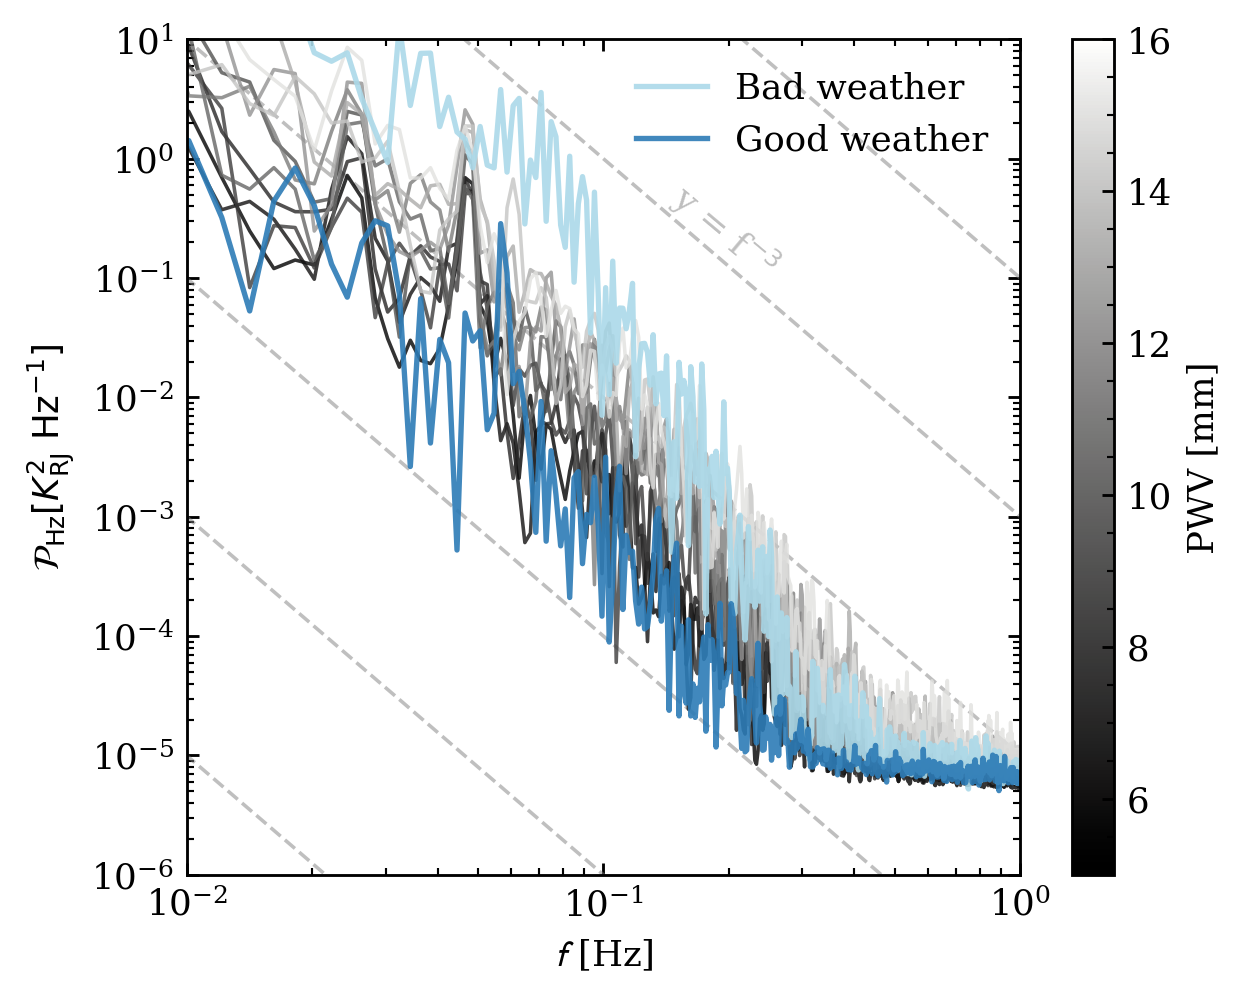

In [17]:
#pwv
fig, ax = plt.subplots(1, 1, figsize=(5, 4), dpi=256, tight_layout=True)

sm_pwv = plt.cm.ScalarMappable(cmap=cmocean.cm.gray, norm=plt.Normalize(vmin=5, vmax=16))

for i in range(-20,20,2): ax.plot(np.logspace(-7, 3,100), np.logspace(-7, 3,100) ** (-3)/1e11/(10**i), c = 'gray', alpha = 0.5, ls = '--', lw = 1)
ax.text(1.4e-1,1e-1, r"y = f$^{-3}$", c = 'gray', alpha = 0.5, rotation = -40)

height = 3e3

ax.set_xlabel(r"$\mathscr{l}$")
ax.set_ylabel(r"$\mathcal{P}_{\rm Hz}[K_{\rm RJ}^2~{\rm Hz}^{-1}]$")

for pwv in np.arange(5,16,1):
    
    f, ps = np.load(
    "/Users/jvanmarr/Documents/Papers/maria/output/9min_change_pwv_{}.npy".format(
       pwv
    ))

    box_pts = 2
    box = np.ones(box_pts)/box_pts
    ax.plot(f[1:], np.convolve(ps[1:], box, mode='same'), c = sm_pwv.to_rgba(pwv),  alpha = 0.8, lw = 1, rasterized=True)

# bad obs
i_file=8
filename = fls[i_file]
mustang2_tod_file = dir + filename
tod_real = TOD.from_fits(fname=mustang2_tod_file, format='mustang-2')
hdu_table = fits.open(mustang2_tod_file)

time_raw = tod_real.time - tod_real.time[0]
tod_raw  = tod_real.data.copy()
f_raw, ps_raw = sp.signal.periodogram(tod_real.data, fs=1/(tod_real.time[1] - tod_real.time[0]), window="tukey")
ax.plot(f_raw[1:], ps_raw.mean(axis=0)[1:], label="Bad weather", alpha = .9, c = 'C1', lw = 1.5, ls = '-', rasterized=True)

# good obs
i_file=3
filename = fls[i_file]
mustang2_tod_file = dir + filename
tod_real = TOD.from_fits(fname=mustang2_tod_file, format='mustang-2')
hdu_table = fits.open(mustang2_tod_file)

time_raw = tod_real.time - tod_real.time[0]
tod_raw  = tod_real.data.copy()
f_raw, ps_raw = sp.signal.periodogram(tod_real.data, fs=1/(tod_real.time[1] - tod_real.time[0]), window="tukey")
ax.plot(f_raw[1:], ps_raw.mean(axis=0)[1:], label="Good weather", alpha = .9, c = 'C0', lw = 1.5, ls = '-', rasterized=True)


ax.legend(markerfirst = True, frameon = False)
ax.loglog()
ax.axis(xmin = 1e-2, xmax = 1e0, ymin = 1e-6, ymax = 10) 
ax.set_xlabel(r"$\mathcal{f}$ [Hz]") 

cbar = plt.colorbar(sm_pwv, ax = ax)
cbar.set_label('PWV [mm]')

plt.savefig('/Users/jvanmarr/Documents/Papers/maria/paper_plots/pwvs.pdf')
plt.show()

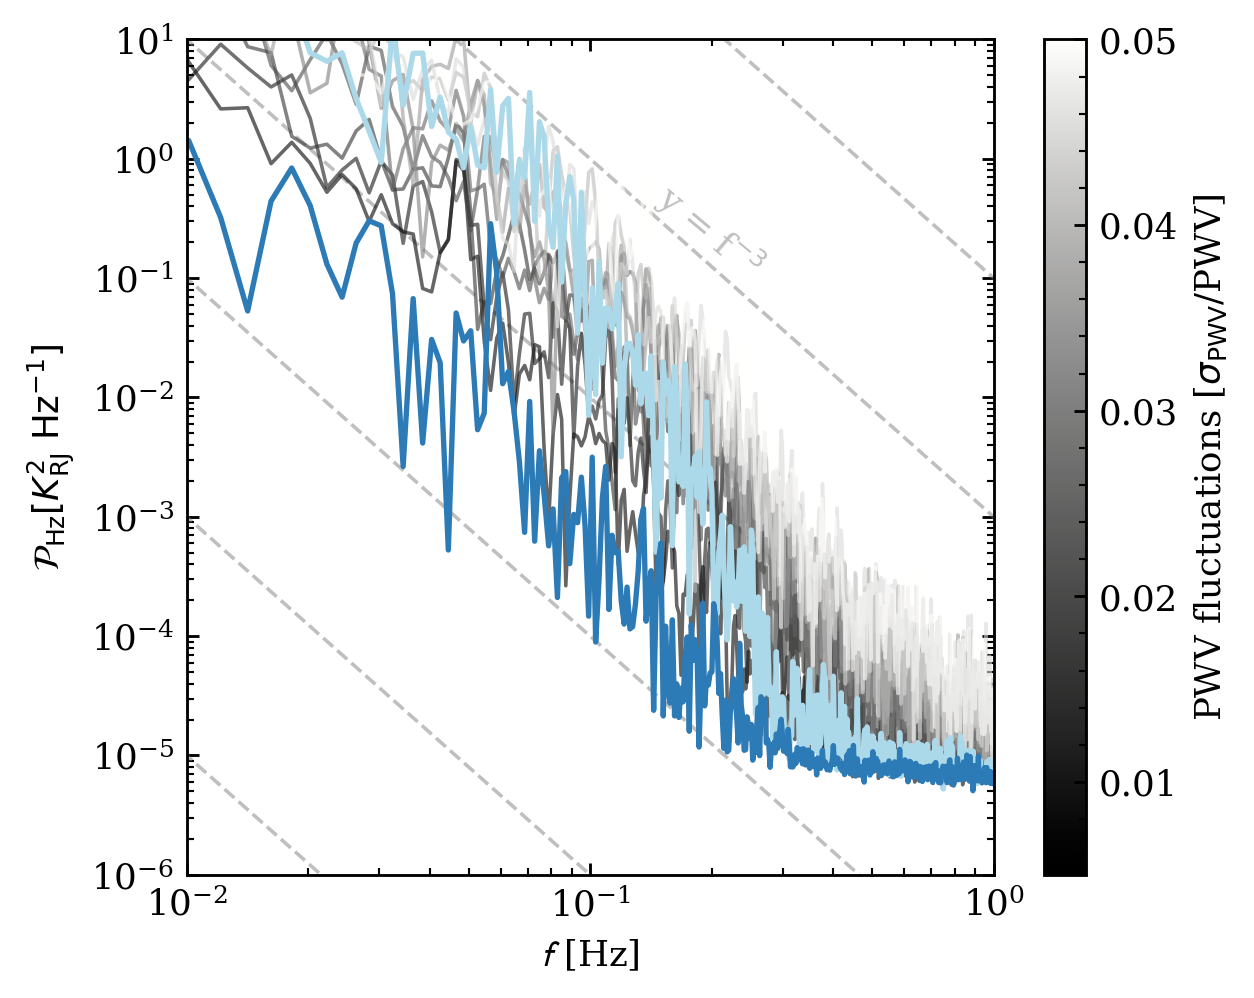

In [18]:
#pwv
fig, ax = plt.subplots(1, 1, figsize=(5, 4), dpi=256, tight_layout=True)

sm_pwv = plt.cm.ScalarMappable(cmap=cmocean.cm.gray, norm=plt.Normalize(vmin=0.005, vmax=0.05))

for i in range(-20,20,2): ax.plot(np.logspace(-7, 3,100), np.logspace(-7, 3,100) ** (-3)/1e11/(10**i), c = 'gray', alpha = 0.5, ls = '--', lw = 1)
ax.text(1.4e-1,1e-1, r"y = f$^{-3}$", c = 'gray', alpha = 0.5, rotation = -40)

height = 3e3

ax.set_xlabel(r"$\mathscr{l}$")
ax.set_ylabel(r"$\mathcal{P}_{\rm Hz}[K_{\rm RJ}^2~{\rm Hz}^{-1}]$")

for pwv_rmss in np.arange(0.005, 0.055, 0.005):
    
    f, ps = np.load(
    "/Users/jvanmarr/Documents/Papers/maria/output/9min_change_pwvrms_{}rms.npy".format(
                  str(pwv_rmss).split(".")[-1]

    ))

    box_pts = 2
    box = np.ones(box_pts)/box_pts
    ax.plot(f[1:], np.convolve(ps[1:], box, mode='same'), c = sm_pwv.to_rgba(pwv_rmss),  alpha = 0.6, lw = 1, rasterized=True)

# bad obs
i_file=8
filename = fls[i_file]
mustang2_tod_file = dir + filename
tod_real = TOD.from_fits(fname=mustang2_tod_file, format='mustang-2')
hdu_table = fits.open(mustang2_tod_file)

time_raw = tod_real.time - tod_real.time[0]
tod_raw  = tod_real.data.copy()
f_raw, ps_raw = sp.signal.periodogram(tod_real.data, fs=1/(tod_real.time[1] - tod_real.time[0]), window="tukey")
ax.plot(f_raw[1:], ps_raw.mean(axis=0)[1:], label="Bad weather", alpha = 1., c = 'C1', lw = 1.5, ls = '-', rasterized=True)

# good obs
i_file=3
filename = fls[i_file]
mustang2_tod_file = dir + filename
tod_real = TOD.from_fits(fname=mustang2_tod_file, format='mustang-2')
hdu_table = fits.open(mustang2_tod_file)

time_raw = tod_real.time - tod_real.time[0]
tod_raw  = tod_real.data.copy()
f_raw, ps_raw = sp.signal.periodogram(tod_real.data, fs=1/(tod_real.time[1] - tod_real.time[0]), window="tukey")
ax.plot(f_raw[1:], ps_raw.mean(axis=0)[1:], label="Good weather", alpha = 1., c = 'C0', lw = 1.5, ls = '-', rasterized=True)


# ax.legend(markerfirst = True, frameon = False)
ax.loglog()
ax.axis(xmin = 1e-2, xmax = 1e0, ymin = 1e-6, ymax = 10) 
ax.set_xlabel(r"$\mathcal{f}$ [Hz]") 

cbar = plt.colorbar(sm_pwv, ax = ax)
cbar.set_label(r'PWV fluctuations [$\sigma_{\rm PWV}$/PWV]')

plt.savefig('/Users/jvanmarr/Documents/Papers/maria/paper_plots/pwvs_rms.pdf')
plt.show()